In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import scipy.stats as ss
import pingouin as pg

from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
t2_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-t-pilipchuk/Fin_p/Проект_1_Задание_2 (1).csv', sep=';')

In [4]:
t2_df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [5]:
t2_df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

В датасете всё чисто, продолжим

In [5]:
t2_df.shape[0]

404770

In [6]:
# Ключевые метрики для обеих групп

users_a = t2_df.query('testgroup == "a"')['user_id'].nunique()
users_b = t2_df.query('testgroup == "b"')['user_id'].nunique()

pay_users_a = t2_df.query('testgroup == "a" & revenue > 0')['user_id'].nunique()
pay_users_b = t2_df.query('testgroup == "b" & revenue > 0')['user_id'].nunique()

conv_a = np.round(pay_users_a / users_a, 4)
conv_b = np.round(pay_users_b / users_b, 4) 

arpu_a = t2_df.query('testgroup == "a"')['revenue'].sum() / users_a
arpu_b = t2_df.query('testgroup == "b"')['revenue'].sum() / users_b

arppu_a = t2_df.query('testgroup == "a"')['revenue'].sum() / pay_users_a
arppu_b = t2_df.query('testgroup == "b"')['revenue'].sum() / pay_users_b

print('Группа A - {} пользователей, из них {} платящих c конверсией {}, ARPU: {:.3f}, ARPPU: {:.3f}'
      .format(users_a, pay_users_a, conv_a, arpu_a, arppu_a))
print('Группа B - {} пользователей, из них {} платящих c конверсией {}, ARPU: {:.3f}, ARPPU: {:.3f}'
      .format(users_b, pay_users_b, conv_b, arpu_b, arppu_b))

Группа A - 202103 пользователей, из них 1928 платящих c конверсией 0.0095, ARPU: 25.414, ARPPU: 2663.998
Группа B - 202667 пользователей, из них 1805 платящих c конверсией 0.0089, ARPU: 26.751, ARPPU: 3003.658


Так как процент платящих пользователей меньше 1%, то следует посмотреть на неплатящих пользователей

In [7]:
paying_groups_df = t2_df[t2_df['revenue'] > 0]  # Отбор пользователей с доходом > 0
paying_groups_df.head()

,user_id,revenue,testgroup
72,73,351,a
160,161,3797,b
341,342,290,a
377,378,3768,b
385,386,250,a


Отфильтруем их по группам

In [8]:
paying_a = paying_groups_df.query('testgroup == "a"')[['revenue']]
paying_a.name = 'Group A'
paying_b = paying_groups_df.query('testgroup == "b"')[['revenue']]
paying_b.name = 'Group B'

Посмотрим на распределение по гистограмме

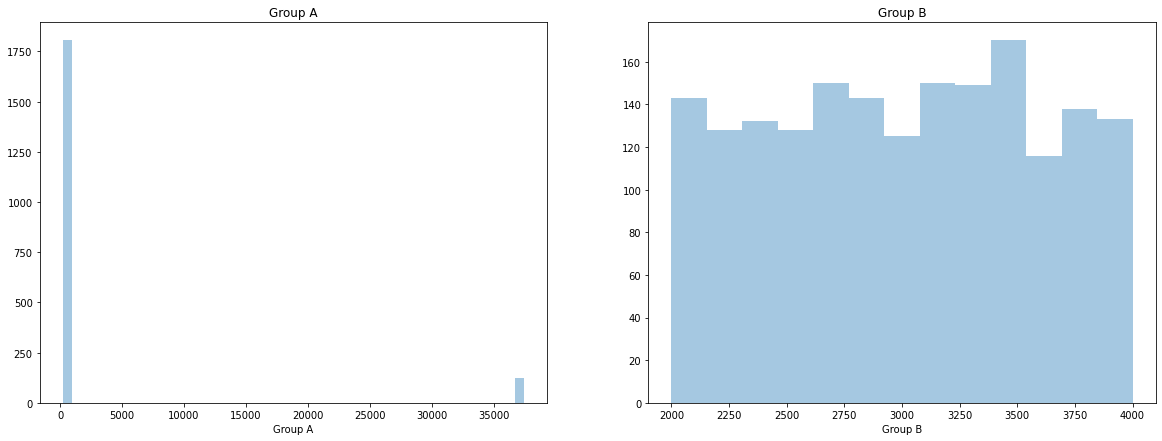

In [9]:
plt.figure(figsize=(20, 7)) 

for i,group in enumerate([paying_a, paying_b]):
    plt.subplot(1, 2, i+1)
    plt.title(group.name)
    sns.distplot(group, kde=False)

In [10]:
paying_a[paying_a.revenue > 1000].shape[0]

123

Количество пользователей группы A - принесшие большую прибыль.

In [11]:
# Доля прибыли с таких пользователей от общей прибыли
print('{:.2f}'.format(*paying_a.query('revenue > 30000').sum() / paying_a.sum()))

0.89


По результатам визуализаций можно сделать вывод, что в контрольной группе (A) присутствует небольшое количество пользователей, доход от которых значительно превышает среднее значение дохода в группе. Возможно, в контрольой группе были использованны акционные предложения, которые привлекли больше пользователей.

Какие есть варианты дальнейшего исследования:
1. Провести анализ результатов эксперимента для всех пользователей, включая тех, у кого доход равен нулю, и не удалять выбросы (учитываем конверсияю и ARPU).
2. Отфильтровать пользователей с высоким доходом, оставив тех, кто значительно отличается от остальных пользователей по уровню дохода (ARPPU, т.к. вычислить только на платящих пользователях не получится).
3. Удалить из выборки пользователей с нулевым доходом и тех, кто сильно отклоняется от основного распределения по уровню дохода (предполагаем, что система сплиования работает некорректно).

In [12]:
# Оценка стат.тестов на исходных группах

print('- Ст.отклонения группы A = {:.3f}, группы B = {:3f}'
          .format(np.std(paying_a)[0], np.std(paying_b)[0]))
print('- P-value для теста Левена = {:.3f}'
          .format(st.levene(paying_a.revenue, paying_b.revenue)[1]))
print('- P-value для U-критерия Манна-Уитни = {:.3f}'
          .format(st.mannwhitneyu(paying_a.revenue, paying_b.revenue)[1]))

- Ст.отклонения группы A = 9046.693, группы B = 572.461067
- P-value для теста Левена = 0.000
- P-value для U-критерия Манна-Уитни = 0.000


На основании полученных графиков и проведенных тестов, необходимо отметить следующее: 
условия для осознанного применения параметрических тестов не были выполнены, оценка теста Левена не позволяет утверждать о гомогенности дисперсий, а также распределения данных отличаются от нормальных, присутствует разное количество наблюдений между группами, а также согласно критерию Манна-Уитни, группы статистически значимо различаются, так как p-value для теста < 0.05 (Н0: распределение данных нормальное p-value = 0.0 < 0.05 => Отклоняем гипотезу). После двух тестов делаем вывод => Распределение - не нормальное.

Для более точных выводов и дальнейшего исследования сравнения групп, предлагается применить метод бутстрап на подвыборках платящих пользователей для оценки среднего показателя ARPPU. Таким образом, мы сможем провести статистический анализ и сделать выводы на основе более надежных данных.

In [12]:
def bootstrap(x, y, n, bootstrap_conf_level = 0.95):
    
    boot_len = max([len(x), len(y)])
    boot_data = []
    
    for i in tqdm(range(n)): 
        samples_1 = x.sample(boot_len, replace = True).values
        samples_2 = y.sample(boot_len, replace = True).values
        boot_data.append(np.mean(samples_1-samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = st.norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = st.norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2
        
    plt.figure(figsize=(10, 7))
    plt.hist(pd_boot_data[0], bins = 50)
    plt.vlines(ci, 0, 600, linestyle='--', colors=['black'])
    plt.xlabel('mean_diff')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    print('2.5%-ый перцентиль:{:.2f}, 97.5%-ый перцентиль:{:.2f}, p-value: {:.3f}'
          .format(ci.values[0][0].astype('float64'), ci.values[1][0].astype('float64'), p_value))

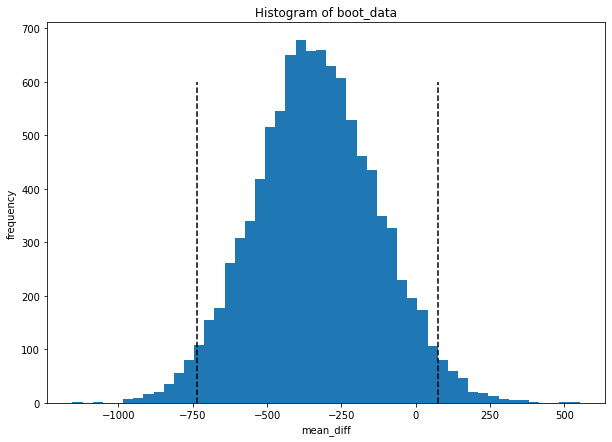

2.5%-ый перцентиль:-736.62, 97.5%-ый перцентиль:75.24, p-value: 0.106


In [14]:
bootstrap(paying_a, paying_b, 10000)

с вероятностью 95% у нас нет оснований отклонить нулевую гипотезу об отсутствии различий ARPPU в двух группах

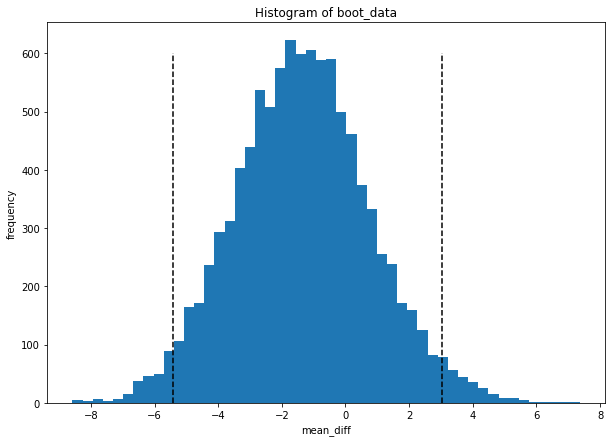

2.5%-ый перцентиль:-5.42, 97.5%-ый перцентиль:3.02, p-value: 0.526


In [15]:
# Используем бутстрап на группах, состоящих из всех пользователей вместе с неплатящими
bootstrap(t2_df.query('testgroup == "a"')['revenue'], 
          t2_df.query('testgroup == "b"')['revenue'], 
          10000)

с вероятностью 95% у нас нет оснований отклонить нулевую гипотезу об отсутствии различий ARPU в двух группах

Из-за небольшого выбора данных, которые у нас есть, посчитаем конверсию в покупку.

# Посчитаем CR
Conversion Rate - доля платящих пользователей среди всех пользователей.

# Сформируем гипотезы:
H0 - CR между группами не различаются

H1 - CR между группами различаются

In [13]:
t2_df['buy'] = t2_df['revenue'].apply(lambda x: 1 if x > 0 else 0)

In [14]:
conversion_data = (t2_df.groupby('testgroup') \
    .agg({'user_id': 'count', 'buy': 'sum'}) \
    .rename(columns={'user_id': 'user_count', 'buy': 'total_buys'}))

In [15]:
conversion_data['conversion'] = round(conversion_data['total_buys'] / conversion_data['user_count'] * 100, 2)
conversion_data

,user_count,total_buys,conversion
testgroup,,,
a,202103,1928,0.95
b,202667,1805,0.89


Проверим зависит ли доля платящих пользователей от группы, используем X-квадрат Пирсона.

In [16]:
tat, p, dof, expected = ss.chi2_contingency(pd.crosstab(t2_df['testgroup'], t2_df['buy']))
p

0.03647561892312613

Выводы:
P-val < 0.05 поэтому мы можем отклонить нулевую гипотезу, соответственно конверсия между группами статистически отличается — в контрольной группе она больше.

# Выводы

1. При исследовании метрики ARPU тест подсказал не отклонять H0;
2. При исследовании метрики ARPPU в двух группах, также не выявил статистических различий;
3. Конверсия между группами статистически отличается — в контрольной группе она больше..

**Рекомендации**:
- Если цель бизнеса - привлекать как можно больше пользователей с наибольшим доходом как в контрольной группе при наличии теоретического CRM отдела для работы с такими пользователями, цель которого не допускать отток и мотивировать их на траты - можно сделать выбор в пользу акционных предложений группы A, однако не гарантируется, что привлечение таких пользователей будет стабильным, требуются дополнительные исследования;
- Если рассматривать общую картину - на основании проведенного исследования мы не выявили значимых различий в показателях ARPU и ARPPU двух групп, а следовательно не можем сделать выбор в пользу акционных предложений контрольной или тестовой группы, основываясь на этих показателях;
- Набор предложений, сформированный для тестовой группы, можно считать не самым лучшим, исходя из полученных результатов метрик. Эти изменения лучше не вводить;
- Выяснив дальнейшую стратегию получения прибыли, а также рассмотрев различия в показателях в совокупности - можем делать вывод в пользу того или иного варианта.